# CNN 2D Basic Solution Powered by fast.ai

This kernel explains basic solution that I've used in the last competition and many of top competitors also.
It's CNN, even ImageNet pretrained model works fine with audio 2D image like data.

Will show:

- Converting audio to 2D image like array, so that we can simply exploit strong CNN classifier.
- fast.ai to build fast and strong multi-label classifier model. Unlike normal use, we need to train from scratch to comply competition rule. (Though if we use ImageNet pretrained model, it converges super fast...)
- With simple codes.

## Update 30-Apr, 2019
- Now fast.ai library ready to use lwlrap as metric: https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8
- And TTA! https://github.com/fastai/fastai/blob/master/fastai/vision/tta.py --> Oops, it might not be effective for this problem. Now planning to update one more...

## Update 28-Apr, 2019

- Removed EasyDict dependency.
- Training steps improved, tuned by running `lr_find()` and `fit_one_cycle()` iteratively.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython
import IPython.display
import PIL

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train_noisy.csv', 'train_curated.csv', 'train_curated', 'sample_submission.csv', 'train_noisy']


## File/folder definitions

- `df` will handle training data.
- `test_df` will handle test data.

In [2]:
DATA = Path('../input')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_CURATED = WORK/'image/trn_curated'
IMG_TRN_NOISY = WORK/'image/train_noisy'
IMG_TEST = WORK/'image/test'
for folder in [WORK, IMG_TRN_CURATED, IMG_TRN_NOISY, IMG_TEST]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

df = pd.read_csv(CSV_TRN_CURATED)
test_df = pd.read_csv(CSV_SUBMISSION)

## Audio conversion to 2D

Almost copyed from my repository: https://github.com/daisukelab/ml-sound-classifier
- Handle sampling rate 44.1kHz as is, no information loss.
- Size of each file will be 128 x L, L is audio seconds x 128; `[128, 256]`  if sound is 2s long.
- Convert to Mel-spectrogram, not MFCC. We are handling general sound rather than human voice. https://en.wikipedia.org/wiki/Spectrogram

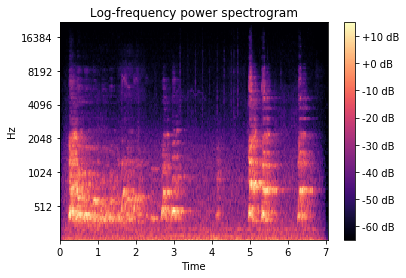

In [3]:
import librosa
import librosa.display

def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

# example
x = read_as_melspectrogram(conf, TRN_CURATED/'0006ae4e.wav', trim_long_data=False, debug_display=True)

## Making 2D mel-spectrogram data as 2D 3ch images

So that normal CNN image classifier can handle.
I wanted to put them into files, but kernel has restriction to keep files less than 500.
We need to keep the data on memory.

Of course this has positive effect, training gets faster.

In [4]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

X_train = convert_wav_to_image(df, source=TRN_CURATED, img_dest=IMG_TRN_CURATED)
X_test = convert_wav_to_image(test_df, source=TEST, img_dest=IMG_TEST)

## Custom `open_image` for fast.ai library to load data from memory

- Important note: Random cropping 1 sec, this is working like augmentation.

In [5]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
import random

CUR_X_FILES, CUR_X = list(df.fname.values), X_train

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

## Follow multi-label classification 

- Almost following fast.ai course: https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb
- But `pretrained=False`
- With lwlrap as metric: https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8

In [6]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])


In [7]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK/'image', Path('../../')/CSV_TRN_CURATED, folder='trn_curated')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats)
)

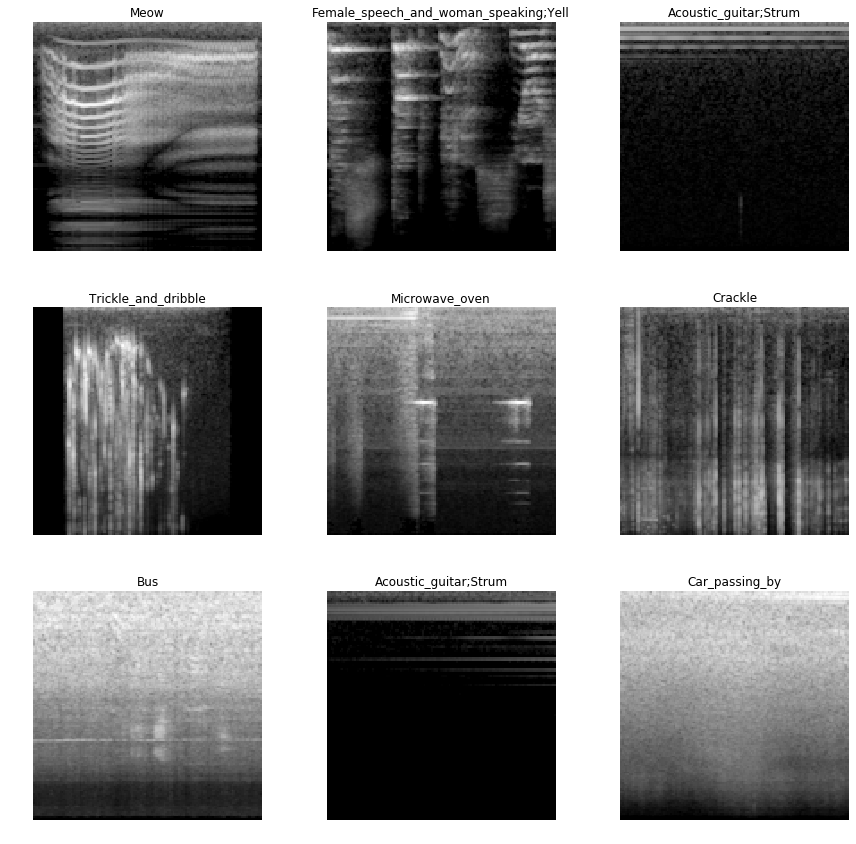

In [8]:
data.show_batch(3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


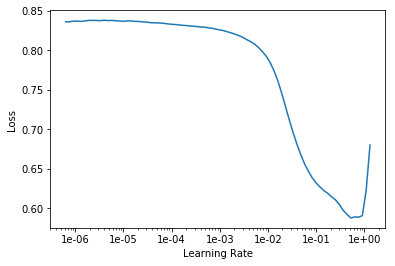

In [9]:
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
learn.unfreeze()

learn.lr_find(); learn.recorder.plot()

In [10]:
learn.fit_one_cycle(5, 1e-1)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,lwlrap,time
0,0.203928,0.164348,0.091409,00:05
1,0.110289,0.174511,0.086719,00:05
2,0.088189,34.831135,0.070577,00:05
3,0.079456,0.071442,0.148072,00:05
4,0.074203,0.069916,0.178260,00:05


epoch,train_loss,valid_loss,lwlrap,time
0,0.071214,0.069382,0.179116,00:05
1,0.071262,0.069877,0.168510,00:05
2,0.071332,0.069054,0.178944,00:05
3,0.070529,0.068207,0.209876,00:05
4,0.069197,0.068022,0.222181,00:06
5,0.068017,0.065331,0.253232,00:05
6,0.066184,0.063583,0.291280,00:05
7,0.064364,0.061482,0.322215,00:05
8,0.063130,0.060965,0.334768,00:05
9,0.062443,0.060407,0.346225,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


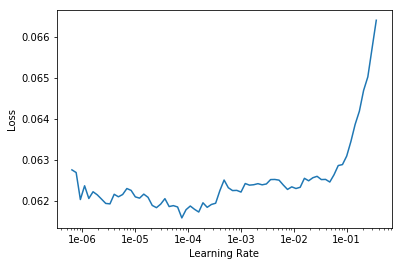

In [11]:
learn.lr_find(); learn.recorder.plot()

In [12]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,lwlrap,time
0,0.061830,0.060072,0.353003,00:06
1,0.061821,0.060473,0.343752,00:05
2,0.061613,0.061397,0.325676,00:05
3,0.061907,0.063665,0.270402,00:05
4,0.061584,0.059111,0.362275,00:05
5,0.061148,0.060216,0.346578,00:05
6,0.060348,0.067014,0.233122,00:06
7,0.058780,399.555054,0.188870,00:06
8,0.057434,0.055850,0.421494,00:05
9,0.056827,0.346531,0.298688,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


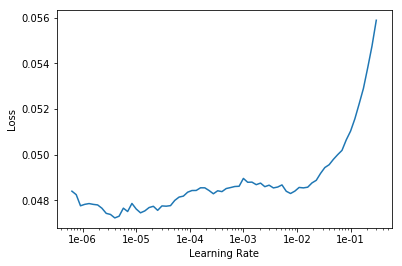

In [13]:
learn.lr_find(); learn.recorder.plot()

In [14]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,lwlrap,time
0,0.048523,0.047671,0.524850,00:06
1,0.048265,0.047725,0.521579,00:05
2,0.048441,0.047325,0.523374,00:05
3,0.047853,0.048110,0.517935,00:05
4,0.047490,0.047423,0.529118,00:05
5,0.047575,0.052010,0.466000,00:05
6,0.047299,0.047783,0.522798,00:05
7,0.046861,0.047567,0.524721,00:05
8,0.046786,0.046482,0.546802,00:05
9,0.046325,0.047439,0.530837,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


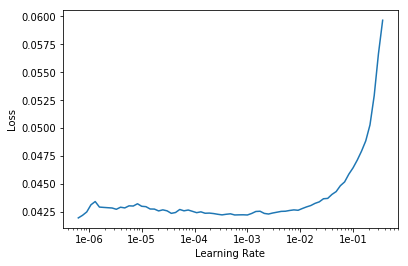

In [15]:
learn.lr_find(); learn.recorder.plot()

In [16]:
learn.fit_one_cycle(50, slice(1e-3, 3e-3))

epoch,train_loss,valid_loss,lwlrap,time
0,0.042792,0.042987,0.591302,00:05
1,0.042829,0.043255,0.582411,00:05
2,0.042896,0.042537,0.597984,00:05
3,0.042663,0.042821,0.585062,00:05
4,0.042635,0.043676,0.573729,00:05
5,0.041898,0.042845,0.595862,00:05
6,0.042173,0.043182,0.591107,00:05
7,0.042239,0.043035,0.589884,00:06
8,0.042053,0.042307,0.593668,00:05
9,0.041809,0.042662,0.592296,00:05


In [17]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,lwlrap,time
0,0.023965,0.035153,0.694046,00:06
1,0.024181,0.034172,0.694478,00:05
2,0.024520,0.035063,0.690447,00:05
3,0.024338,0.040201,0.682518,00:05
4,0.024613,0.035896,0.683450,00:05
5,0.024057,0.034727,0.695909,00:05
6,0.023886,0.034688,0.704743,00:05
7,0.022997,0.034314,0.697536,00:05
8,0.023156,0.034111,0.701091,00:05
9,0.023103,0.034318,0.700705,00:05


## Let's check how filters are

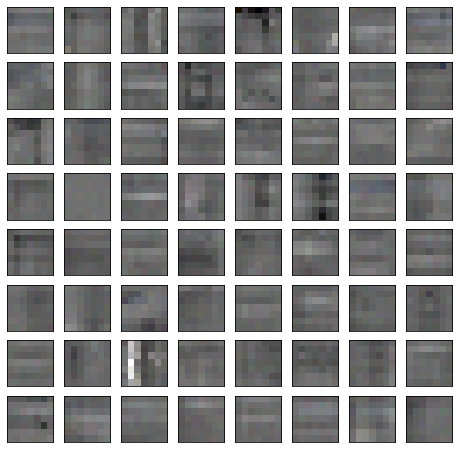

In [18]:
# https://discuss.pytorch.org/t/how-to-visualize-the-actual-convolution-filters-in-cnn/13850
from sklearn.preprocessing import minmax_scale

def visualize_first_layer(learn, save_name=None):
    conv1 = list(learn.model.children())[0][0]
    if isinstance(conv1, torch.nn.modules.container.Sequential):
        conv1 = conv1[0] # for some models, 1 layer inside
    weights = conv1.weight.data.cpu().numpy()
    weights_shape = weights.shape
    weights = minmax_scale(weights.ravel()).reshape(weights_shape)
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.rollaxis(weights[i], 0, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save_name:
        fig.savefig(str(save_name))

visualize_first_layer(learn)

In [19]:
learn.save('fat2019_fastai_cnn2d_stage-2')
learn.export()

## Test prediction and making submission file simple
- Switch to test data.
- Overwrite results to sample submission; simple way to prepare submission file.
- Now using TTA (Test Time Augmentation)!

In [20]:
CUR_X_FILES, CUR_X = list(test_df.fname.values), X_test

test = ImageList.from_csv(WORK/'image', Path('../..')/CSV_SUBMISSION, folder='test')
learn = load_learner(WORK/'image', test=test)
preds, _ = learn.TTA(ds_type=DatasetType.Test) # <== Simply replacing from learn.get_preds()

In [21]:
test_df[learn.data.classes] = preds
test_df.to_csv('submission.csv', index=False)
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0.000013,9.970533e-08,3.473719e-08,1.873726e-07,1.301975e-05,0.006470,9.908513e-07,0.000133,0.003112,5.046152e-07,0.000006,0.000430,0.000005,4.607442e-07,0.001231,0.000004,0.002197,0.000206,0.000001,3.969246e-05,0.000281,0.004354,0.025158,6.187171e-07,0.000031,0.002850,0.000144,0.000201,0.014322,6.903894e-08,9.695070e-06,0.000003,0.000329,0.000244,0.003412,0.001242,5.525422e-06,0.000116,0.000048,...,0.000064,0.058324,0.018721,0.539354,0.000057,1.458908e-07,0.000003,0.000019,0.000001,0.000029,0.000051,0.000006,0.000080,0.000014,0.000001,0.007238,0.000162,0.088561,0.000008,0.002674,0.000146,0.000177,2.646949e-07,0.000099,0.000243,0.000218,0.000055,1.689723e-08,0.000119,0.000168,0.000125,9.526367e-07,0.000042,0.000117,0.001511,3.935163e-06,0.000074,0.003315,0.000019,1.462621e-04
1,0012633b.wav,0.069694,3.735964e-05,9.331258e-05,1.868762e-04,2.750302e-03,0.002367,4.016840e-03,0.013227,0.000130,7.114648e-03,0.029497,0.004165,0.008113,1.045855e-04,0.004766,0.001196,0.002417,0.001869,0.002085,9.034519e-04,0.000478,0.000997,0.000470,7.290817e-04,0.002315,0.005776,0.003077,0.010982,0.000449,1.252580e-03,6.673461e-03,0.000115,0.000365,0.002682,0.000161,0.015461,1.199709e-03,0.000018,0.000624,...,0.000595,0.009059,0.056243,0.000490,0.001572,1.072964e-03,0.000671,0.000010,0.008253,0.012473,0.005717,0.134031,0.015391,0.054019,0.001114,0.000380,0.006930,0.016646,0.000320,0.006908,0.011938,0.023799,1.069381e-03,0.006612,0.006463,0.009707,0.001584,5.894733e-05,0.000494,0.001804,0.016947,9.015515e-03,0.000179,0.007283,0.020767,7.754098e-03,0.001709,0.013110,0.000561,2.638385e-02
2,001ed5f1.wav,0.000024,6.408121e-05,4.881012e-07,5.531685e-05,8.694142e-04,0.005299,2.855616e-06,0.005469,0.000123,2.367274e-05,0.000721,0.000206,0.000369,1.472878e-05,0.027271,0.000074,0.001299,0.000054,0.000021,2.628397e-02,0.001969,0.000563,0.000003,3.437232e-05,0.012334,0.015417,0.001137,0.025501,0.000843,2.283214e-04,3.175377e-01,0.000004,0.000195,0.000152,0.003671,0.000993,4.234897e-04,0.000002,0.000209,...,0.000179,0.007597,0.002752,0.001295,0.001197,2.826711e-06,0.000110,0.000006,0.000076,0.000131,0.004609,0.000048,0.007138,0.000035,0.000007,0.001088,0.319040,0.060460,0.000016,0.006505,0.001072,0.000385,2.009055e-04,0.010048,0.011799,0.034090,0.000232,3.989229e-07,0.018655,0.003045,0.000119,1.883437e-04,0.000060,0.226648,0.000665,1.777923e-04,0.000378,0.009750,0.000041,1.588306e-02
3,00294be0.wav,0.000541,1.968583e-06,4.641604e-06,2.855069e-04,3.024319e-03,0.001338,2.751027e-04,0.010923,0.000048,4.943169e-03,0.001688,0.001560,0.000252,1.988697e-04,0.102733,0.000536,0.003098,0.005035,0.000239,3.272697e-04,0.004168,0.045500,0.001426,7.414895e-04,0.000560,0.002584,0.000721,0.005891,0.002528,1.263323e-05,5.681226e-04,0.000133,0.000679,0.026443,0.000085,0.018667,5.814618e-05,0.000004,0.000020,...,0.000033,0.000676,0.022125,0.009170,0.000731,3.233617e-04,0.002405,0.000034,0.000156,0.007038,0.000285,0.

In [22]:
CUR_X_FILES, CUR_X = list(df.fname.values), X_train
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
learn.load('fat2019_fastai_cnn2d_stage-2');

## Visualize by CAM

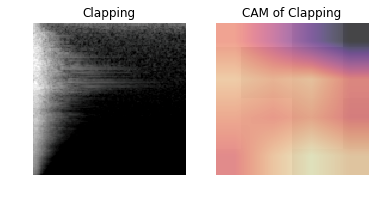

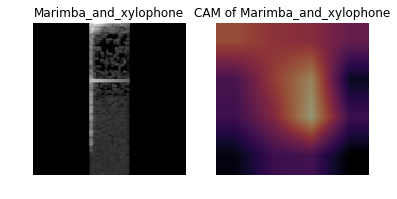

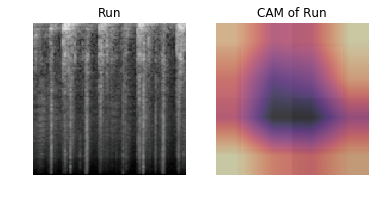

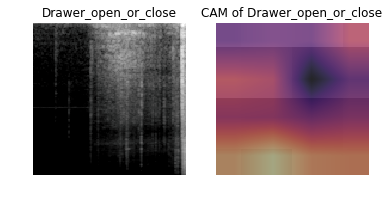

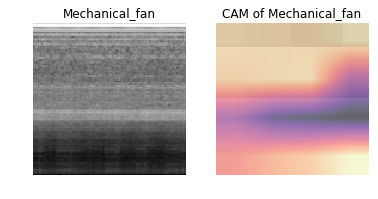

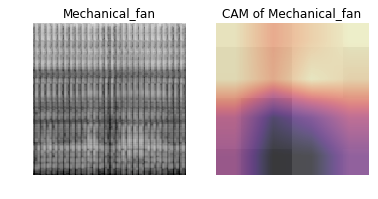

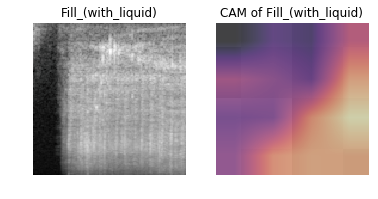

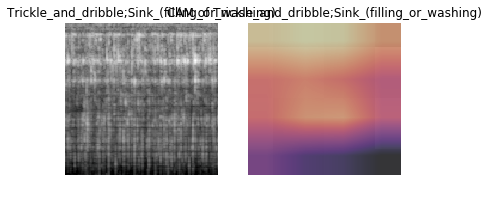

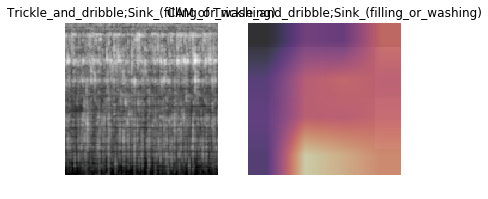

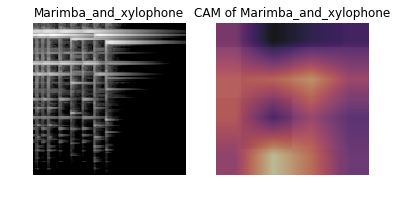

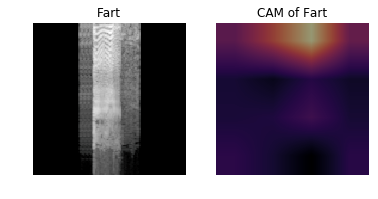

In [23]:
# Thanks to https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb
from fastai.callbacks.hooks import *

def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[0],img.shape[0],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(10):
    visualize_cnn_by_cam(learn, idx)